In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback

torch.cuda.set_device(3) 

codes = pd.read_csv("dataset/codes.csv")
def snomedConvert(code,snomed=True):
    codes = pd.read_csv("dataset/codes.csv")[["Dx","SNOMED CT Code"]]
    
    if snomed:
        df.columns = [codes[codes["SNOMED CT Code"] == x].iloc[0]["Dx"] for x in df.columns]
        return df

In [2]:
df = pd.read_csv("dataset/WFDB_Ga.csv")
df

,6374002,11157007,17338001,27885002,39732003,47665007,49578007,55930002,59118001,59931005,...,429622005,445118002,445211001,698252002,713422000,713426002,713427006,67741000119109,headers,leads
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00001.hea,dataset/WFDB_Ga/E00001.mat
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00002.hea,dataset/WFDB_Ga/E00002.mat
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00003.hea,dataset/WFDB_Ga/E00003.mat
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00004.hea,dataset/WFDB_Ga/E00004.mat
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00005.hea,dataset/WFDB_Ga/E00005.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10339,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10340.hea,dataset/WFDB_Ga/E10340.mat
10340,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10341.hea,dataset/WFDB_Ga/E10341.mat
10341,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10342.hea,dataset/WFDB_Ga/E10342.mat
10342,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,dataset/WFDB_Ga/E10343.hea,dataset/WFDB_Ga/E10343.mat


In [3]:
X = np.load('./dataset/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
df = pd.read_csv("dataset/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(df)
y = y[y.columns[0]].to_numpy()
y

array([ True, False, False, ..., False, False, False])

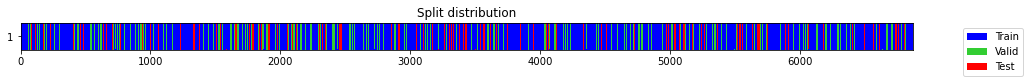

((#4815) [2849,6802,4096,496,2012,173,1178,5343,505,5739...],
 (#1375) [4964,5847,413,6628,1735,5258,6065,3308,3619,3857...],
 (#687) [2626,5678,5053,2717,3363,963,5856,5471,1253,148...])

In [4]:
splits = get_splits(y, valid_size=.2,test_size=0.1, stratify=True, random_state=23, shuffle=True)
splits

# Multi Label Problem

In [5]:
df = pd.read_csv("dataset/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [ ]:


def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    nf = trial.suggest_categorical('num_filters', [32, 64, 96]) # search through all categorical values in the provided list
    depth = trial.suggest_int('depth', 3, 9, step=3) # search through all integer values between 3 and 9 with 3 increment steps
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
    batch_tfms = TSStandardize(by_sample=True)
    tfms  = [None, TSMultiLabelClassification()]
    batch_tfms = [TSStandardize(by_sample=True)]
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 

    model = InceptionTimePlus(dls.vars, dls.c, dls.len,nf=nf, fc_dropout=dropout_rate, depth=depth)
    learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


#     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
    learn.fit_one_cycle(100, lr_max=learning_rate)

    # Return the objective value
    print(learn.recorder.values)
    return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

study_name = "inception" # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize')

study.optimize(objective, n_trials=100)

[I 2022-03-02 17:06:47,027] Trial 1 finished with value: 0.7952028512954712 and parameters: {'num_filters': 96, 'depth': 9, 'dropout_rate': 0.1, 'learning_rate': 0.003094321254500233}. Best is trial 1 with value: 0.7952028512954712.


[[0.28980904817581177, 0.24010241031646729, 0.9162827730178833, 0.6781156063079834, 0.8424873948097229, 0.3654981255531311, 0.9907331466674805, 0.5084222555160522], [0.23582300543785095, 0.21861355006694794, 0.9205656051635742, 0.7158618569374084, 0.7965608835220337, 0.44713568687438965, 0.9845879673957825, 0.5715578198432922], [0.20525823533535004, 0.21081089973449707, 0.9225859642028809, 0.7524024248123169, 0.7469419240951538, 0.5290237665176392, 0.9757811427116394, 0.6191141605377197], [0.18200717866420746, 0.17637020349502563, 0.9364041090011597, 0.7818306088447571, 0.8360748291015625, 0.5789738297462463, 0.9846875667572021, 0.6838133335113525], [0.1697685867547989, 0.19488275051116943, 0.9289697408676147, 0.7793919444084167, 0.7639981508255005, 0.5830870270729065, 0.9756968021392822, 0.6612029671669006], [0.1608472764492035, 0.20639681816101074, 0.9266262650489807, 0.7592926025390625, 0.7757390141487122, 0.5396852493286133, 0.9788999557495117, 0.6357299089431763], [0.1599574536085

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.500585,0.441758,0.892606,0.551638,0.949964,0.104102,0.999173,0.186932,00:13
1,0.408385,0.361680,0.899717,0.585248,0.923007,0.172516,0.997981,0.289946,00:13
2,0.348256,0.317031,0.901414,0.592923,0.921605,0.188050,0.997797,0.311735,00:13
3,0.306808,0.282392,0.905293,0.617433,0.872727,0.239637,0.995229,0.374876,00:13
4,0.276095,0.258175,0.908121,0.629879,0.880005,0.264711,0.995046,0.405589,00:13
5,0.252914,0.242454,0.913455,0.661823,0.848920,0.331536,0.992110,0.475567,00:13
6,0.236191,0.229182,0.913858,0.673448,0.812764,0.357902,0.988993,0.496053,00:13
7,0.223602,0.226487,0.917414,0.698628,0.795006,0.411473,0.985783,0.541359,00:13
8,0.213802,0.212074,0.922586,0.713663,0.831058,0.439436,0.987889,0.574144,00:13
9,0.205828,0.232631,0.910949,0.710405,0.695541,0.447137,0.973673,0.543588,00:13


In [ ]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
# model = MiniRocketPlus(dls.vars, dls.c,2500)
model = InceptionTimePlus(dls.vars, dls.c, dls.len)
learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=ShowGraph())
learn.fit_one_cycle(250, lr_max=1e-4)
learn.recorder.plot_metrics()

In [ ]:
PATH = Path('./models/inception_multilabel.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

In [29]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
y_true_binarized.shape,y_pred_binarized.shape,valid_targets.shape, valid_preds.shape

((3, 4), (3, 4), torch.Size([1375, 9]), torch.Size([1375, 9]))

In [37]:
valid_preds

tensor([[-2.8148, -4.9112, -6.3279,  ..., -6.1543, -4.1439, -1.8683],
        [-4.5751, -4.2064, -6.9157,  ..., -2.2946, -4.3831, -2.9754],
        [-6.2168, -5.1133, -5.8867,  ..., -5.5832, -3.9516, -4.1079],
        ...,
        [-6.7097, -2.4491, -5.7601,  ..., -4.6763, -4.9490, -4.1837],
        [-3.1242, -4.2065, -5.2237,  ..., -3.6501, -4.3118, -1.4268],
        [-5.8146, -1.1107, -2.7918,  ..., -2.1967, -4.7103, -1.7117]])

In [51]:
from sklearn.metrics import classification_report
y_pred=np.argmax(valid_preds, axis=1)
y_test=np.argmax(valid_targets, axis=1)

print(classification_report(y_test, y_pred,target_names = df.columns))

                              precision    recall  f1-score   support

   right bundle branch block       0.78      0.78      0.78       130
        ventricular ectopics       0.85      0.74      0.79       258
         atrial fibrillation       0.67      0.81      0.73        36
    left bundle branch block       0.36      0.22      0.27       123
                st elevation       0.80      0.93      0.86       315
         1st degree av block       0.67      0.67      0.67       203
premature atrial contraction       0.62      0.77      0.69       154
                sinus rhythm       0.54      0.31      0.39        42
               st depression       0.56      0.57      0.56       114

                    accuracy                           0.71      1375
                   macro avg       0.65      0.64      0.64      1375
                weighted avg       0.70      0.71      0.70      1375

